## This demo is a learning note from this github https://github.com/bentrevett/pytorch-sentiment-analysis/tree/main.

### Learn how to retrain a word embedding using existing word embedding.

Torchtext0.15.1 and Torch2.0.0 are compatible with each other for this demo!!

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar 15 17:03:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install torchtext==0.15.1 --no-cache-dir
!pip install torch==2.0.0 --no-cache-dir
!pip install datasets

!pip show torchtext
!pip show torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 182.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 185.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 248.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 188.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 228.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 155.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 341.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 253.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 271.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 231.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 274.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 227.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import io
import os
import re
import shutil
import string
import torch
import torchtext

In [ ]:
# check whether gpu is available
torch.cuda.is_available()

True

In [ ]:

from datasets import load_dataset

imdb = load_dataset("imdb")

train_dataset = imdb["train"]
test_dataset = imdb["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [ ]:
train_dataset, test_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [ ]:
import numpy as np

seed = 1234

# for reproductibility
np.random.seed(seed)
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed) # Set the seed for generating random numbers for the current GPU
# torch.backends.cudnn.deterministic = True
# lets you configure PyTorch to use deterministic algorithms instead of nondeterministic ones
# where available,
# and to throw an error if an operation is known to be nondeterministic

In [ ]:
# tokenization
import torchtext
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
def text_tokenizer_example(example, tokenizer, max_length):
  tokens = tokenizer(example["text"])
  tokens = tokens[:max_length] # we only get all the words upto index max_length
  length = len(tokens)
  out = {"tokens": tokens, "length": length}
  return out

In [ ]:
max_length = 256
train_dataset = train_dataset.map(text_tokenizer_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
test_dataset = test_dataset.map(text_tokenizer_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'length': Value(dtype='int64', id=None)}

In [ ]:
# create validation set

ratio =0.25

tra_data = train_dataset.train_test_split(test_size=ratio)
train_dataset = tra_data["train"]
valid_dataset = tra_data['test']

In [ ]:
train_dataset['label'][:20]

[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'length': Value(dtype='int64', id=None)}

In [ ]:
# build vocabulary

min_freq = 5 # retrive words that appears at least 5 times in the entire dataset
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [ ]:
len(vocab)

21635

In [ ]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [ ]:
# set the default token if words that are not in this vocab
vocab.set_default_index(unk_index)
vocab['some_tokens']

# to look up the indices of some words
vocab.lookup_indices(["hello", "world", "views", "<pad>"])

[5516, 184, 2810, 1]

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(18750, 6250, 25000)

In [ ]:
# make sure all datasets have the same features sets and same mapping
# get the token ids for each sample
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}


train_data = train_dataset.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_dataset.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_dataset.map(numericalize_example, fn_kwargs={"vocab": vocab})


Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
print(train_data[0]['ids'][:10])
print(len(train_data[0]['ids']))

[180, 4, 14, 10, 191, 841, 34, 7, 2, 121]
135


In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'length': Value(dtype='int64', id=None),
 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
vocab.lookup_tokens(train_data[0]["ids"][:10])

['look', ',', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the', 'best']

In [ ]:
# convert the data into tensors
train_data = train_data.with_format(type="torch", columns=["ids", "label","length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label","length"])

In [ ]:
train_data[0]

{'label': tensor(1),
 'length': tensor(135),
 'ids': tensor([  180,     4,    14,    10,   191,   841,    34,     7,     2,   121,
            98,   816,    50,     8,  1516,     2,   380,     7,     2,   184,
             3,     8,   805,    14,    18,    10,     8,   805,  2246,   429,
             3,    12,   347,    15,     2,   388,  1025,     9,    16,    76,
             5,    64,     7, 11198,     3,     2,  9212,    17,   761,     4,
          7812,  5460,   198,    37,     4,     6,  3653,  3683,    17,   226,
             5, 11893,     3,    53,     7,    15,  3310,   354,     5,   689,
             4,     0,  5471,     3,  2706,  3826,     9,    16,   246,    13,
            14,    18,  1111,    33,    17,   126,   188,     8,    35,   597,
           181,    19,     5,    34,  3942,  1381,    13,     2,  5370,     3,
            32,  4228,    10,    41,  2825,     8,    37,     3,     2,  4411,
          1141,   213,  2655,     6, 16946,  3729,   590,  4845,     8,  2416,


In [ ]:

import collections
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm
# the next is to create data loaders, we can get batch samples when training, we also need to do padding
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}

        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.14it/s]


epoch: 0
train_loss: 0.629, train_acc: 0.636
valid_loss: 0.495, valid_acc: 0.756


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.05it/s]


epoch: 1
train_loss: 0.469, train_acc: 0.780
valid_loss: 0.399, valid_acc: 0.829


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.12it/s]


epoch: 2
train_loss: 0.412, train_acc: 0.813
valid_loss: 0.364, valid_acc: 0.847


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.19it/s]


epoch: 3
train_loss: 0.368, train_acc: 0.840
valid_loss: 0.348, valid_acc: 0.848


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.15it/s]


epoch: 4
train_loss: 0.327, train_acc: 0.860
valid_loss: 0.323, valid_acc: 0.870


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.92it/s]


epoch: 5
train_loss: 0.290, train_acc: 0.883
valid_loss: 0.316, valid_acc: 0.877


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.79it/s]


epoch: 6
train_loss: 0.282, train_acc: 0.883
valid_loss: 0.313, valid_acc: 0.883


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.11it/s]


epoch: 7
train_loss: 0.249, train_acc: 0.898
valid_loss: 0.296, valid_acc: 0.887


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.02it/s]


epoch: 8
train_loss: 0.228, train_acc: 0.910
valid_loss: 0.295, valid_acc: 0.884


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.83it/s]


epoch: 9
train_loss: 0.225, train_acc: 0.912
valid_loss: 0.300, valid_acc: 0.881


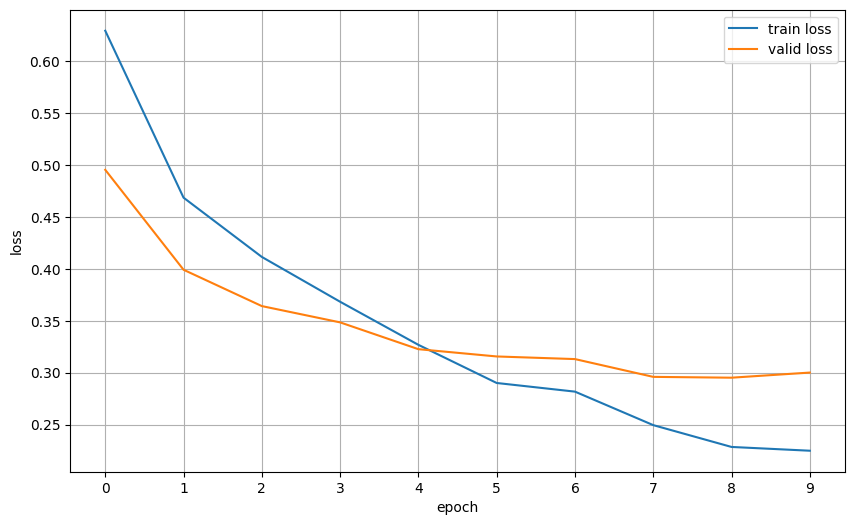

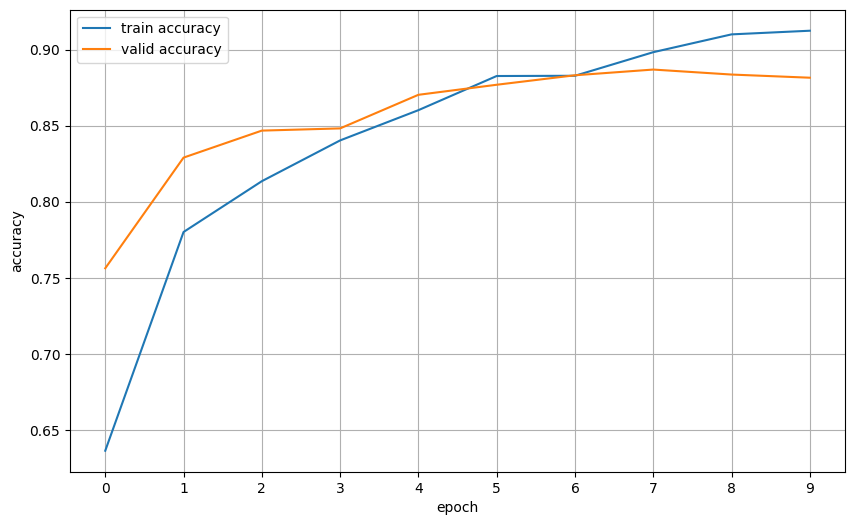

In [ ]:
# build model use embedding dimension 300, and hidden state 300, and
class myLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=pad_index)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(
            hidden_dim * 2 if bidirectional else hidden_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.bidirectional =bidirectional

    def forward(self, ids, length):
        embedded_with_dropout = self.dropout(self.embedding(ids))
        # print('embedded_with_dropout shape: ', embedded_with_dropout.shape)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_with_dropout,
            length,
            batch_first=True,
            enforce_sorted=False,
        )
        # print('packed embedded shape: ', embedded_with_dropout.shape)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # print( 'Hidden shape: ',hidden.shape)
        # print( 'Cell shape: ',cell.shape)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.bidirectional:
            hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
        else:
            hidden = self.dropout(hidden[-1])
        # print('hidden shape: ', hidden.shape)
        prediction = self.fc(hidden)
        return prediction


vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = myLSTM(
    vocab_size, embedding_dim,hidden_dim,
    output_dim,n_layers, bidirectional,
    dropout_rate,pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# print(f"The model has {count_parameters(model):,} trainable parameters")

# def initialize_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.xavier_normal_(m.weight)
#         nn.init.zeros_(m.bias)
#     elif isinstance(m, nn.LSTM):
#         for name, param in m.named_parameters():
#             if "bias" in name:
#                 nn.init.zeros_(param)
#             elif "weight" in name:
#                 nn.init.orthogonal_(param)

# print(model.apply(initialize_weights))

# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="300")
# vectors = torchtext.vocab.GloVe()


vectors.get_vecs_by_tokens(["hello", "<pad>"])


pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)




# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

The model has 2,567,102 trainable parameters


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 18.64it/s]


epoch: 0
train_loss: 0.684, train_acc: 0.549
valid_loss: 0.658, valid_acc: 0.611


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.46it/s]


epoch: 1
train_loss: 0.623, train_acc: 0.652
valid_loss: 0.629, valid_acc: 0.688


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.75it/s]


epoch: 2
train_loss: 0.541, train_acc: 0.725
valid_loss: 0.491, valid_acc: 0.756


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.44it/s]


epoch: 3
train_loss: 0.493, train_acc: 0.766
valid_loss: 0.454, valid_acc: 0.793


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.51it/s]


epoch: 4
train_loss: 0.456, train_acc: 0.790
valid_loss: 0.481, valid_acc: 0.788


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.26it/s]


epoch: 5
train_loss: 0.430, train_acc: 0.806
valid_loss: 0.403, valid_acc: 0.831


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 24.10it/s]


epoch: 6
train_loss: 0.410, train_acc: 0.813
valid_loss: 0.377, valid_acc: 0.830


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.91it/s]


epoch: 7
train_loss: 0.385, train_acc: 0.829
valid_loss: 0.383, valid_acc: 0.831


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 24.09it/s]


epoch: 8
train_loss: 0.358, train_acc: 0.844
valid_loss: 0.337, valid_acc: 0.862


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 23.95it/s]


epoch: 9
train_loss: 0.340, train_acc: 0.856
valid_loss: 0.393, valid_acc: 0.840


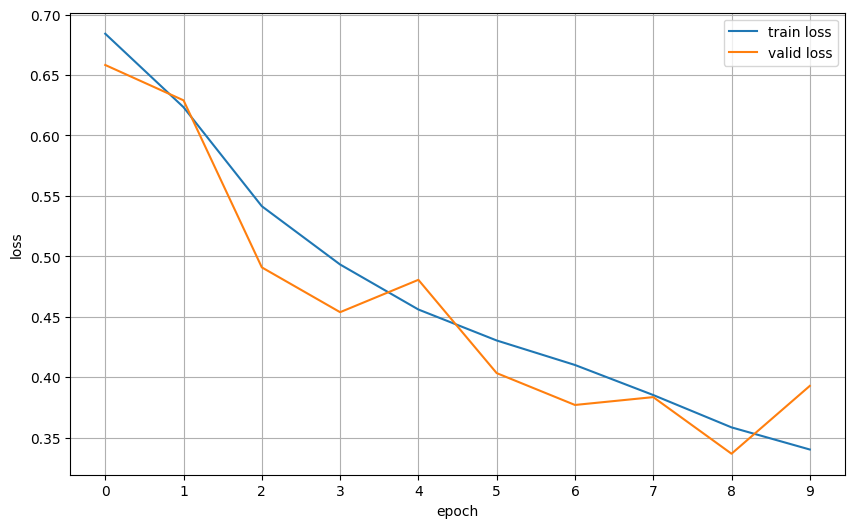

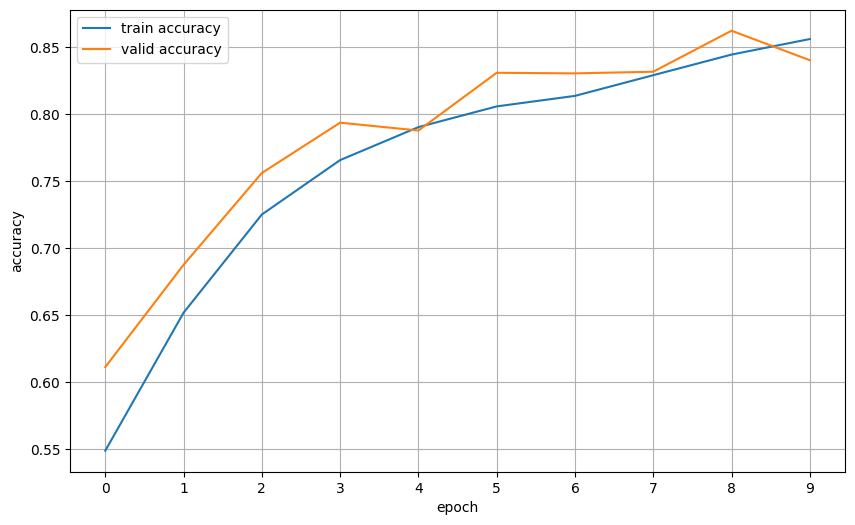

In [ ]:
# here I changed the embedding dimesion to 100, the hidden state to 100, and change dropout to 0.5, and add a weight initilization layer
# NOTE: the result is a little worser than the 300 embedding dimension and 300 hidden states

batch_size = 512
# Larger batches: With larger batches, the gradients become more stable and less noisy.
# This means the model's updates are smoother and more deterministic, which can lead to faster convergence but also a higher risk of overfitting,
# as the model may settle on a solution that fits the specific training data very closely.

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


# build model
class myLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=pad_index)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(
            hidden_dim * 2 if bidirectional else hidden_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.bidirectional =bidirectional

    def forward(self, ids, length):
        embedded_with_dropout = self.dropout(self.embedding(ids))
        # print('embedded_with_dropout shape: ', embedded_with_dropout.shape)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_with_dropout,
            length,
            batch_first=True,
            enforce_sorted=False,
        )
        # print('packed embedded shape: ', embedded_with_dropout.shape)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # print( 'Hidden shape: ',hidden.shape)
        # print( 'Cell shape: ',cell.shape)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.bidirectional:
            hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
        else:
            hidden = self.dropout(hidden[-1])
        # print('hidden shape: ', hidden.shape)
        prediction = self.fc(hidden)
        return prediction


vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 100
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = myLSTM(vocab_size, embedding_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)
# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="100")
vectors.get_vecs_by_tokens(["hello", "<pad>"])
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)




# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

The model has 5,294,302 trainable parameters


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.48it/s]


epoch: 0
train_loss: 0.659, train_acc: 0.601
valid_loss: 0.645, valid_acc: 0.633


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.42it/s]


epoch: 1
train_loss: 0.624, train_acc: 0.661
valid_loss: 0.591, valid_acc: 0.700


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.46it/s]


epoch: 2
train_loss: 0.547, train_acc: 0.727
valid_loss: 0.474, valid_acc: 0.776


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.48it/s]


epoch: 3
train_loss: 0.572, train_acc: 0.703
valid_loss: 0.502, valid_acc: 0.755


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.31it/s]


epoch: 4
train_loss: 0.502, train_acc: 0.758
valid_loss: 0.429, valid_acc: 0.811


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.48it/s]


epoch: 5
train_loss: 0.433, train_acc: 0.801
valid_loss: 0.505, valid_acc: 0.736


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.42it/s]


epoch: 6
train_loss: 0.477, train_acc: 0.772
valid_loss: 0.383, valid_acc: 0.837


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 26.44it/s]


epoch: 7
train_loss: 0.401, train_acc: 0.823
valid_loss: 0.390, valid_acc: 0.837


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.18it/s]


epoch: 8
train_loss: 0.385, train_acc: 0.835
valid_loss: 0.479, valid_acc: 0.778


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.38it/s]


epoch: 9
train_loss: 0.367, train_acc: 0.840
valid_loss: 0.459, valid_acc: 0.768


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.96it/s]


epoch: 10
train_loss: 0.354, train_acc: 0.848
valid_loss: 0.388, valid_acc: 0.841


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.82it/s]


epoch: 11
train_loss: 0.309, train_acc: 0.871
valid_loss: 0.335, valid_acc: 0.860


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.41it/s]


epoch: 12
train_loss: 0.300, train_acc: 0.876
valid_loss: 0.383, valid_acc: 0.814


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.05it/s]


epoch: 13
train_loss: 0.286, train_acc: 0.882
valid_loss: 0.316, valid_acc: 0.876


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.59it/s]


epoch: 14
train_loss: 0.277, train_acc: 0.884
valid_loss: 0.318, valid_acc: 0.877


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.42it/s]


epoch: 15
train_loss: 0.268, train_acc: 0.890
valid_loss: 0.339, valid_acc: 0.866


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.63it/s]


epoch: 16
train_loss: 0.246, train_acc: 0.901
valid_loss: 0.323, valid_acc: 0.878


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.40it/s]


epoch: 17
train_loss: 0.265, train_acc: 0.895
valid_loss: 0.335, valid_acc: 0.863


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.33it/s]


epoch: 18
train_loss: 0.237, train_acc: 0.906
valid_loss: 0.320, valid_acc: 0.878


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.01it/s]


epoch: 19
train_loss: 0.220, train_acc: 0.912
valid_loss: 0.349, valid_acc: 0.873


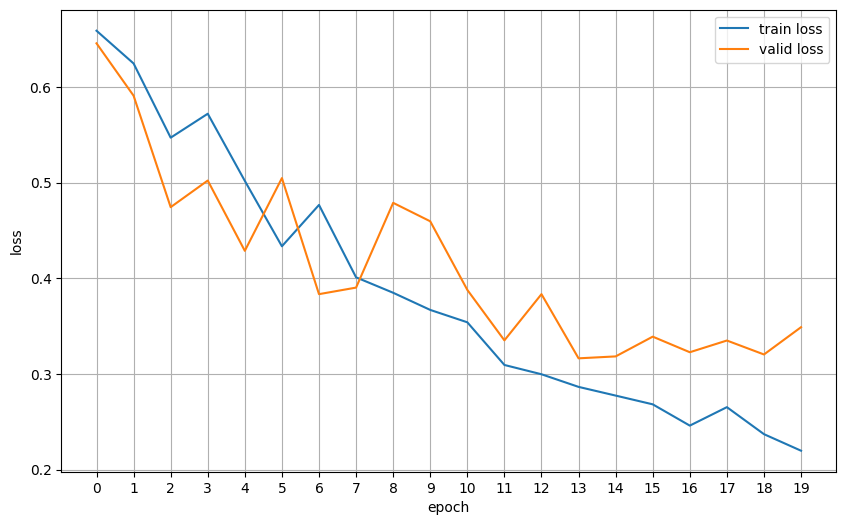

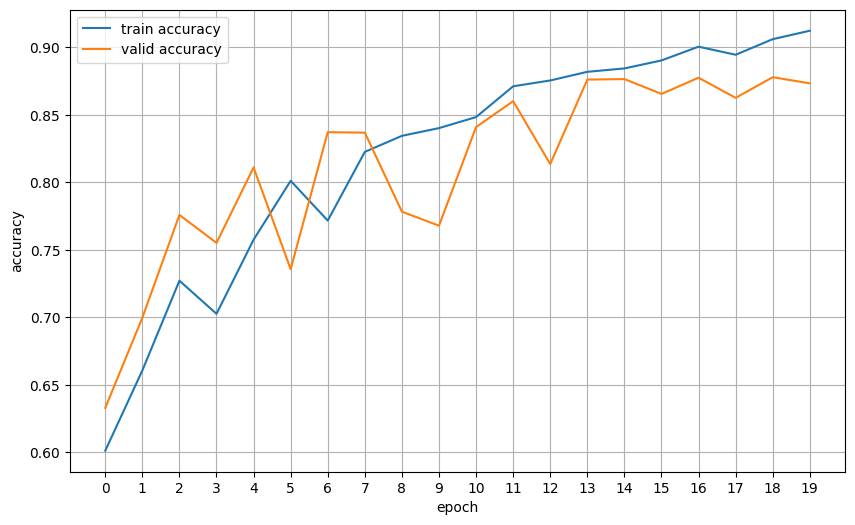

In [ ]:
# here I changed the embedding dimesion to 100, the hidden state to 300, and change dropout to 0.5, and add a weight initilization layer
# As I learned here, that a large hidden state will learn deep concepts, however the training and valid accuracy fluctures during the middle of training
# so I changed the batch size to 256 to see the impact, and the result is more stable and smooth.

batch_size = 256
# Larger batches: With larger batches, the gradients become more stable and less noisy.
# This means the model's updates are smoother and more deterministic, which can lead to faster convergence but also a higher risk of overfitting,
# as the model may settle on a solution that fits the specific training data very closely.

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


# build model
class myLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=pad_index)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(
            hidden_dim * 2 if bidirectional else hidden_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.bidirectional =bidirectional

    def forward(self, ids, length):
        embedded_with_dropout = self.dropout(self.embedding(ids))
        # print('embedded_with_dropout shape: ', embedded_with_dropout.shape)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_with_dropout,
            length,
            batch_first=True,
            enforce_sorted=False,
        )
        # print('packed embedded shape: ', embedded_with_dropout.shape)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # print( 'Hidden shape: ',hidden.shape)
        # print( 'Cell shape: ',cell.shape)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.bidirectional:
            hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
        else:
            hidden = self.dropout(hidden[-1])
        # print('hidden shape: ', hidden.shape)
        prediction = self.fc(hidden)
        return prediction


vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = myLSTM(vocab_size, embedding_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)
# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="100")
vectors.get_vecs_by_tokens(["hello", "<pad>"])
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape


model.embedding.weight.data = pretrained_embedding


optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)




# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


n_epochs = 20
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
# print all parameters
# for param in model.parameters():
#     print(param.requires_grad)

# if we want to freeze some parameters of the model
# for param in some_model_layer.parameters():
#     param.requires_grad_(False)

# or for the entire model
# for param in model.parameters():
#     param.requires_grad_(False)

In [ ]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0324, -0.0163,  0.0159,  ...,  0.0179, -0.0258, -0.0351],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0186, -0.2494,  0.7253,  ..., -0.1559,  0.8299,  0.2525],
        ...,
        [-0.0441, -0.2212, -0.0889,  ..., -0.1748, -0.2060,  0.9692],
        [ 0.3195,  0.5869, -0.1864,  ...,  0.1366, -0.9730,  0.3434],
        [-0.6877,  0.5713, -0.7666,  ...,  0.3945, -0.3057,  0.0039]],
       device='cuda:0', requires_grad=True)

In [ ]:
pretrained_embedding[3][:10]

tensor([-0.3398,  0.2094,  0.4635, -0.6479, -0.3838,  0.0380,  0.1713,  0.1598,
         0.4662, -0.0192])

In [ ]:
# prompt: given the model, predict a new text

import torch

# Load the saved model
vocab_size = len(vocab)
embedding_dim = 100
output_dim = len(train_data.unique("label"))
model = myLSTM(vocab_size, embedding_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index)
model.load_state_dict(torch.load("nbow.pt"))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move the model to the desired device

def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9709641933441162)

In [ ]:
txt = 'I like this movie! this movie is fantastic'
res = predict_sentiment(txt, model, tokenizer, vocab, device)
print(res)

text = "This film is terrible!"
res = predict_sentiment(text, model, tokenizer, vocab, device)
print(res)

txt = "This movie was absolutely fantastic!"
res = predict_sentiment(txt, model, tokenizer, vocab, device)
print(res)


text = "This film is great!"
res = predict_sentiment(text, model, tokenizer, vocab, device)
print(res)

(1, 0.9668495655059814)
(0, 0.9709641933441162)
(1, 0.9601166248321533)
(1, 0.9849985241889954)


In [ ]:
# check the embeddings after training
model.embedding.weight.data[3]

tensor([-0.3210,  0.1904,  0.4754, -0.6461, -0.3852,  0.0415,  0.1476,  0.1672,
         0.4770, -0.0060,  0.4267, -0.3231,  0.2759,  0.0426,  0.4374, -0.3998,
         0.1351,  0.0332, -0.6230,  0.2351,  0.0175, -0.1822,  0.4556,  0.4593,
         0.6690,  0.0855,  0.2218, -0.6708,  0.1561, -0.3270, -0.1134,  0.6627,
        -0.2626,  0.0172, -0.1439,  0.3741,  0.1451,  0.3600, -0.1012, -0.4351,
        -0.2358, -0.2855, -0.1347, -0.2462, -0.2200, -0.4638,  0.2863, -0.8310,
        -0.1534, -0.4759,  0.0239, -0.1560,  0.2598,  1.3648, -0.2149, -2.7959,
        -0.2802, -0.4308,  1.5949,  0.7633, -0.5602,  0.6330,  0.1086,  0.3962,
         1.0580, -0.3349,  0.4768,  0.3267,  0.8233,  0.0976, -0.2355, -0.2814,
         0.0682, -0.3664,  0.0636, -0.0048,  0.0375,  0.0368, -1.0133, -0.1907,
         0.6389, -0.0890, -0.5933,  0.3089, -1.1314, -0.1060, -0.2267, -0.4171,
        -0.0782, -0.1647, -0.0701, -0.6418, -0.0788,  0.5192, -0.8405,  0.3007,
        -0.3707, -0.2142,  0.4327, -0.04

In [ ]:
word = 'woman'
word_indice = vocab[word]
word_indices = torch.LongTensor([word_indice]).to(device)
word_embedding = model.embedding(word_indices)
print(word_embedding)


tensor([[ 0.6786,  0.3871,  0.6873,  0.0225,  0.0721,  1.3506,  0.0588,  0.2474,
          0.4704,  0.3495, -0.6781,  0.4192,  0.8324,  0.4126,  0.2453, -0.0465,
          0.4234, -0.1764, -0.4088,  0.3913,  0.1603,  0.0345,  0.0909,  0.3846,
          0.5573,  0.4517, -0.4830, -1.5328,  0.1827,  0.2862,  0.2698,  0.5559,
          0.5807, -0.3970,  0.1627, -0.6707, -0.7060,  0.2034,  1.1474,  0.4889,
         -0.9198,  0.1184,  0.1343, -0.2343,  0.2645,  0.1471, -0.2429,  0.2099,
          0.1272, -0.2715, -0.2135, -0.3024,  0.7780,  1.6180, -0.4136, -1.9868,
         -0.7397,  0.3183,  1.2120,  0.5759,  0.3784,  0.6578, -0.1442,  0.0295,
          0.7545,  0.1608,  0.8980,  0.3432, -0.4611,  0.0199,  0.0984, -0.1312,
         -0.1232,  0.5948,  0.4814,  0.7794,  0.0710, -0.5830, -0.7231, -1.0418,
         -0.0271,  0.2741,  0.4480,  0.0593, -1.2957, -1.2742,  0.1630,  0.4380,
          0.0918, -0.7256,  0.8179, -0.1567,  0.7464, -0.0946, -0.3741,  0.4106,
         -0.5218, -0.5155,  

## Freeze the embedding layer and see the impact


The model has 5,294,302 trainable parameters


.vector_cache/glove.6B.zip: 862MB [02:45, 5.21MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 22080.46it/s]


tensor([-0.3398,  0.2094,  0.4635, -0.6479, -0.3838,  0.0380,  0.1713,  0.1598,
         0.4662, -0.0192,  0.4148, -0.3435,  0.2687,  0.0446,  0.4213, -0.4103,
         0.1546,  0.0222, -0.6465,  0.2526,  0.0431, -0.1945,  0.4652,  0.4565,
         0.6859,  0.0913,  0.2188, -0.7035,  0.1679, -0.3508, -0.1263,  0.6638,
        -0.2582,  0.0365, -0.1361,  0.4025,  0.1429,  0.3813, -0.1228, -0.4589,
        -0.2528, -0.3043, -0.1121, -0.2618, -0.2248, -0.4455,  0.2991, -0.8561,
        -0.1450, -0.4909,  0.0083, -0.1749,  0.2752,  1.4401, -0.2124, -2.8435,
        -0.2796, -0.4572,  1.6386,  0.7881, -0.5526,  0.6500,  0.0864,  0.3901,
         1.0632, -0.3538,  0.4833,  0.3460,  0.8417,  0.0987, -0.2421, -0.2705,
         0.0453, -0.4015,  0.1139,  0.0062,  0.0367,  0.0185, -1.0213, -0.2081,
         0.6407, -0.0688, -0.5864,  0.3348, -1.1432, -0.1148, -0.2509, -0.4591,
        -0.0968, -0.1795, -0.0634, -0.6741, -0.0689,  0.5360, -0.8777,  0.3180,
        -0.3924, -0.2339,  0.4730, -0.02

evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.47it/s]


epoch: 0
train_loss: 0.660, train_acc: 0.605
valid_loss: 0.653, valid_acc: 0.669


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.69it/s]


epoch: 1
train_loss: 0.669, train_acc: 0.605
valid_loss: 0.617, valid_acc: 0.671


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.26it/s]


epoch: 2
train_loss: 0.609, train_acc: 0.667
valid_loss: 0.574, valid_acc: 0.696


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.70it/s]


epoch: 3
train_loss: 0.617, train_acc: 0.654
valid_loss: 0.604, valid_acc: 0.665


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.77it/s]


epoch: 4
train_loss: 0.603, train_acc: 0.677
valid_loss: 0.647, valid_acc: 0.660


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.13it/s]


epoch: 5
train_loss: 0.596, train_acc: 0.685
valid_loss: 0.562, valid_acc: 0.738


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.49it/s]


epoch: 6
train_loss: 0.549, train_acc: 0.721
valid_loss: 0.569, valid_acc: 0.702


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.62it/s]


epoch: 7
train_loss: 0.545, train_acc: 0.728
valid_loss: 0.497, valid_acc: 0.774


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.38it/s]


epoch: 8
train_loss: 0.540, train_acc: 0.735
valid_loss: 0.479, valid_acc: 0.775


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.66it/s]


epoch: 9
train_loss: 0.510, train_acc: 0.748
valid_loss: 0.577, valid_acc: 0.734


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.69it/s]


epoch: 10
train_loss: 0.521, train_acc: 0.744
valid_loss: 0.493, valid_acc: 0.764


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.40it/s]


epoch: 11
train_loss: 0.487, train_acc: 0.771
valid_loss: 0.477, valid_acc: 0.787


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.38it/s]


epoch: 12
train_loss: 0.478, train_acc: 0.771
valid_loss: 0.424, valid_acc: 0.810


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 29.70it/s]


epoch: 13
train_loss: 0.460, train_acc: 0.783
valid_loss: 0.428, valid_acc: 0.803


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.54it/s]


epoch: 14
train_loss: 0.446, train_acc: 0.790
valid_loss: 0.386, valid_acc: 0.830


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.66it/s]


epoch: 15
train_loss: 0.430, train_acc: 0.801
valid_loss: 0.398, valid_acc: 0.812


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.16it/s]


epoch: 16
train_loss: 0.421, train_acc: 0.807
valid_loss: 0.387, valid_acc: 0.831


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 30.16it/s]


epoch: 17
train_loss: 0.415, train_acc: 0.812
valid_loss: 0.392, valid_acc: 0.831


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 29.80it/s]


epoch: 18
train_loss: 0.408, train_acc: 0.817
valid_loss: 0.414, valid_acc: 0.808


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.26it/s]


epoch: 19
train_loss: 0.404, train_acc: 0.818
valid_loss: 0.350, valid_acc: 0.849


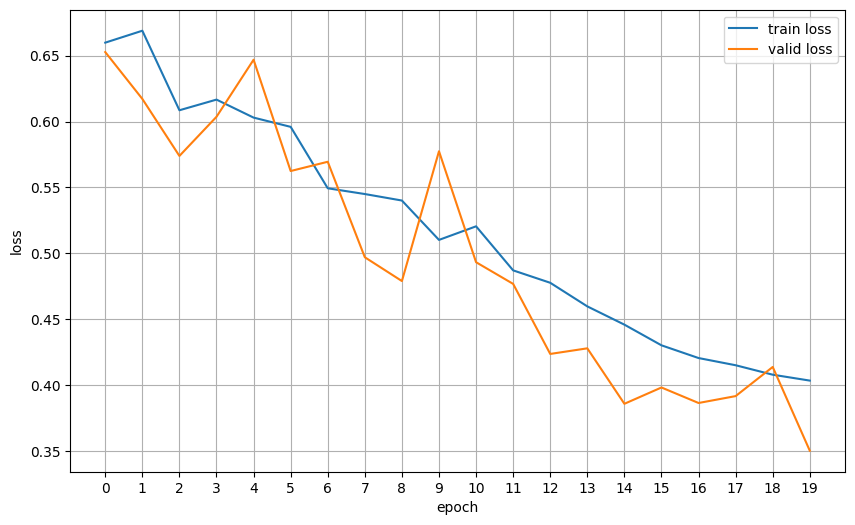

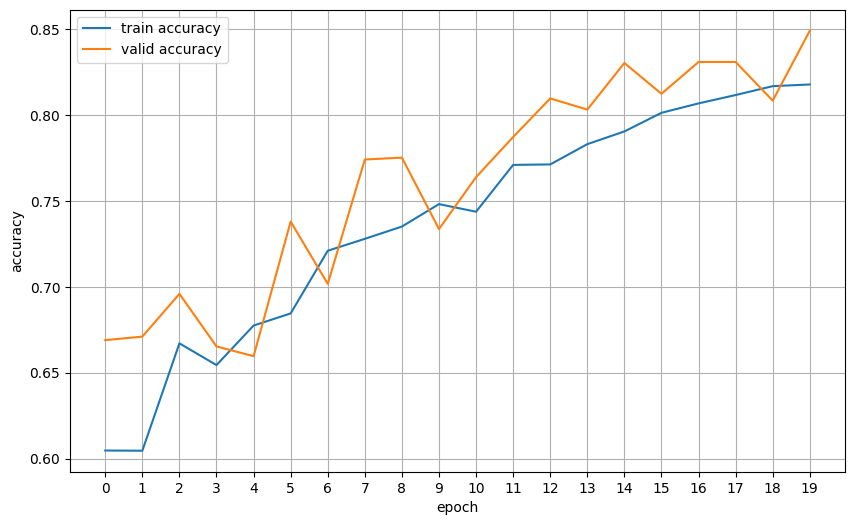

In [ ]:
# here I changed the embedding dimesion to 100, the hidden state to 300, and change dropout to 0.5, and add a weight initilization layer
# As I learned here, that a large hidden state will learn deep concepts, however the training and valid accuracy fluctures during the middle of training
# so I changed the batch size to 256 to see the impact, and the result is more stable and smooth.

batch_size = 256
# Larger batches: With larger batches, the gradients become more stable and less noisy.
# This means the model's updates are smoother and more deterministic, which can lead to faster convergence but also a higher risk of overfitting,
# as the model may settle on a solution that fits the specific training data very closely.

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


# build model
class myLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=pad_index)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(
            hidden_dim * 2 if bidirectional else hidden_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.bidirectional =bidirectional

    def forward(self, ids, length):
        embedded_with_dropout = self.dropout(self.embedding(ids))
        # print('embedded_with_dropout shape: ', embedded_with_dropout.shape)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_with_dropout,
            length,
            batch_first=True,
            enforce_sorted=False,
        )
        # print('packed embedded shape: ', embedded_with_dropout.shape)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # print( 'Hidden shape: ',hidden.shape)
        # print( 'Cell shape: ',cell.shape)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.bidirectional:
            hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
        else:
            hidden = self.dropout(hidden[-1])
        # print('hidden shape: ', hidden.shape)
        prediction = self.fc(hidden)
        return prediction


vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = myLSTM(vocab_size, embedding_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)
# use existing word embedding as the start points
vectors = torchtext.vocab.GloVe(name="6B", dim="100")
vectors.get_vecs_by_tokens(["hello", "<pad>"])
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape
model.embedding.weight.data = pretrained_embedding

print(model.embedding.weight.data[3])

for param in model.embedding.parameters():
    param.requires_grad = False


optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


n_epochs = 20
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
print(model.embedding.weight.data[3])

tensor([-0.3398,  0.2094,  0.4635, -0.6479, -0.3838,  0.0380,  0.1713,  0.1598,
         0.4662, -0.0192,  0.4148, -0.3435,  0.2687,  0.0446,  0.4213, -0.4103,
         0.1546,  0.0222, -0.6465,  0.2526,  0.0431, -0.1945,  0.4652,  0.4565,
         0.6859,  0.0913,  0.2188, -0.7035,  0.1679, -0.3508, -0.1263,  0.6638,
        -0.2582,  0.0365, -0.1361,  0.4025,  0.1429,  0.3813, -0.1228, -0.4589,
        -0.2528, -0.3043, -0.1121, -0.2618, -0.2248, -0.4455,  0.2991, -0.8561,
        -0.1450, -0.4909,  0.0083, -0.1749,  0.2752,  1.4401, -0.2124, -2.8435,
        -0.2796, -0.4572,  1.6386,  0.7881, -0.5526,  0.6500,  0.0864,  0.3901,
         1.0632, -0.3538,  0.4833,  0.3460,  0.8417,  0.0987, -0.2421, -0.2705,
         0.0453, -0.4015,  0.1139,  0.0062,  0.0367,  0.0185, -1.0213, -0.2081,
         0.6407, -0.0688, -0.5864,  0.3348, -1.1432, -0.1148, -0.2509, -0.4591,
        -0.0968, -0.1795, -0.0634, -0.6741, -0.0689,  0.5360, -0.8777,  0.3180,
        -0.3924, -0.2339,  0.4730, -0.02

# train the embeeding from scratch, not using the exising embedding

The model has 2,567,102 trainable parameters
tensor([-2.7397e-01, -1.2954e+00, -3.4245e+00,  6.5716e-01,  2.9377e-01,
         1.2856e+00,  3.4306e-01,  1.3520e+00, -1.2914e+00, -1.2462e+00,
        -9.7697e-01, -2.1026e+00, -5.9336e-01, -5.6034e-01, -4.3856e-01,
         1.1725e+00,  9.5350e-02, -5.3999e-04, -3.0765e-01, -1.4029e+00,
         1.1543e+00,  2.6972e-01, -7.7573e-01, -1.0396e+00,  1.7007e-01,
         1.6631e-01, -1.2300e-02, -1.4504e+00, -1.1356e+00,  1.5457e+00,
         4.0253e-01,  1.8608e+00, -6.1534e-01,  1.3610e-01, -3.1957e-01,
        -4.8321e-01, -2.1358e-02,  1.0209e-01,  1.0611e+00,  3.9634e-01,
         9.6753e-01,  1.9975e+00,  1.1455e+00,  1.0798e+00,  1.1787e+00,
        -3.0427e-01, -1.7199e-01,  1.2505e+00,  1.0226e+00,  7.4067e-01,
        -1.5913e+00, -5.4952e-01,  3.0380e-01, -1.9832e+00,  5.1833e-01,
         1.2792e+00, -1.2871e+00, -1.0258e-01, -4.1426e-01,  2.3744e-01,
        -2.4618e+00, -1.7746e-01,  3.7322e-01, -4.5643e-01,  1.4476e-01,
      

evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.15it/s]


epoch: 0
train_loss: 0.680, train_acc: 0.556
valid_loss: 0.665, valid_acc: 0.596


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 33.19it/s]


epoch: 1
train_loss: 0.630, train_acc: 0.644
valid_loss: 0.579, valid_acc: 0.701


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.98it/s]


epoch: 2
train_loss: 0.603, train_acc: 0.674
valid_loss: 0.538, valid_acc: 0.727


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 32.82it/s]


epoch: 3
train_loss: 0.571, train_acc: 0.703
valid_loss: 0.555, valid_acc: 0.728


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 32.79it/s]


epoch: 4
train_loss: 0.546, train_acc: 0.724
valid_loss: 0.501, valid_acc: 0.758


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 33.05it/s]


epoch: 5
train_loss: 0.521, train_acc: 0.740
valid_loss: 0.534, valid_acc: 0.730


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 31.94it/s]


epoch: 6
train_loss: 0.510, train_acc: 0.745
valid_loss: 0.512, valid_acc: 0.757


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 32.87it/s]


epoch: 7
train_loss: 0.504, train_acc: 0.756
valid_loss: 0.497, valid_acc: 0.781


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 32.00it/s]


epoch: 8
train_loss: 0.548, train_acc: 0.718
valid_loss: 0.769, valid_acc: 0.576


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 32.62it/s]


epoch: 9
train_loss: 0.523, train_acc: 0.741
valid_loss: 0.485, valid_acc: 0.774


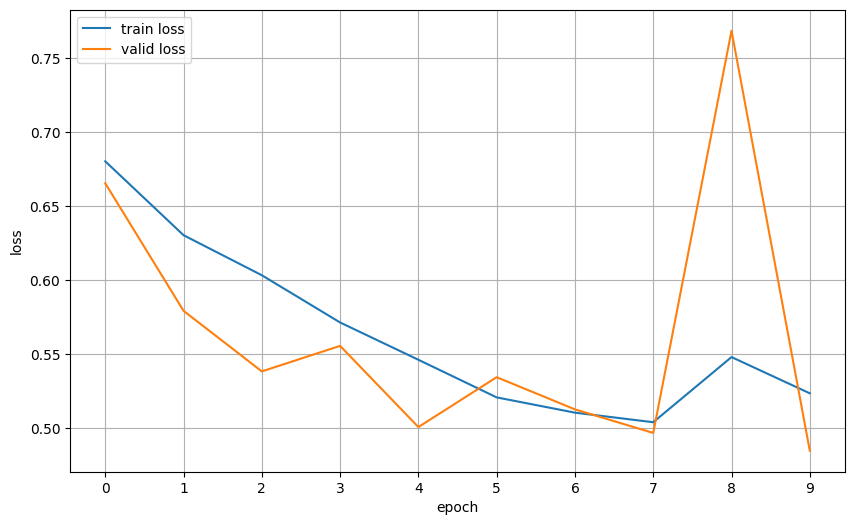

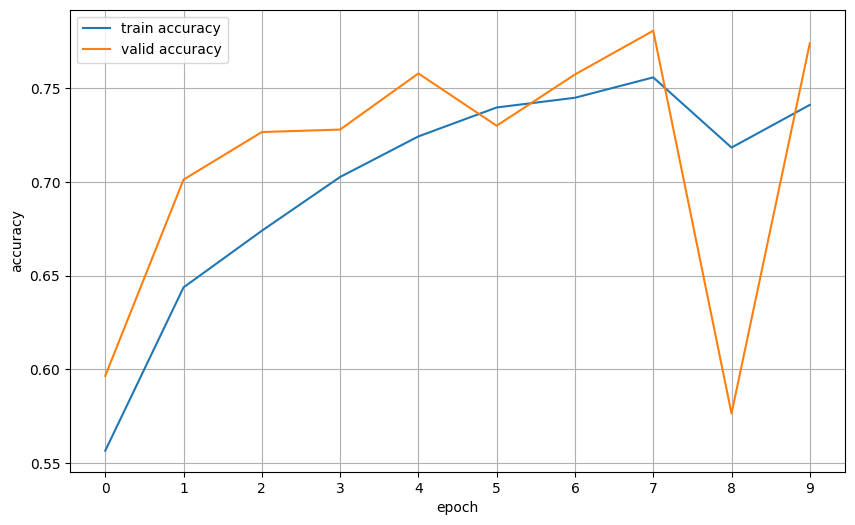

In [ ]:
# I randomly initilize the word embedding and the validation loss is flucturing, (kind of overfitting) so I lower the hidden state, and
# the validation loss is more stable


batch_size = 256
# Larger batches: With larger batches, the gradients become more stable and less noisy.
# This means the model's updates are smoother and more deterministic, which can lead to faster convergence but also a higher risk of overfitting,
# as the model may settle on a solution that fits the specific training data very closely.

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


# build model
class myLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=pad_index)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(
            hidden_dim * 2 if bidirectional else hidden_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.bidirectional =bidirectional

    def forward(self, ids, length):
        embedded_with_dropout = self.dropout(self.embedding(ids))
        # print('embedded_with_dropout shape: ', embedded_with_dropout.shape)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_with_dropout,
            length,
            batch_first=True,
            enforce_sorted=False,
        )
        # print('packed embedded shape: ', embedded_with_dropout.shape)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # print( 'Hidden shape: ',hidden.shape)
        # print( 'Cell shape: ',cell.shape)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.bidirectional:
            hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
        else:
            hidden = self.dropout(hidden[-1])
        # print('hidden shape: ', hidden.shape)
        prediction = self.fc(hidden)
        return prediction


vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 100
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = myLSTM(vocab_size, embedding_dim,hidden_dim, output_dim,n_layers, bidirectional, dropout_rate,pad_index)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)
# use existing word embedding as the start points
# vectors = torchtext.vocab.GloVe(name="6B", dim="100")
# vectors.get_vecs_by_tokens(["hello", "<pad>"])
# pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
# pretrained_embedding.shape
# model.embedding.weight.data = pretrained_embedding

embedding_layer = nn.Embedding(vocab_size, embedding_dim)
embedding_layer.weight.data.uniform_(-1, 1)

print(model.embedding.weight.data[3])


optimizer = optim.Adam(model.parameters(), lr=8e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this is to move tensor to device to speed up
model = model.to(device)
criterion = criterion.to(device)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    # torch.no_grad() is a context manager in PyTorch that disables gradient calculations.
    # It's used when you want to perform operations without tracking gradients,
    # which can be useful for inference or when you're sure you won't need to call backward() on the resulting tensors.
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)



# train the model

# optimizer.zero_grad()is a method in PyTorch used to reset the gradients of all optimized tensors to zero before each training iteration.
# By default, gradients in PyTorch accumulate with each backward pass.
# Failing to clear them would cause the optimizer to use the accumulated gradients from previous iterations,
# leading to incorrect updates of the model's parameters and hindering the training process.
# It is called before loss.backward() and optimizer.step()
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        # print(ids.shape, 'id shape')
        # print(label.shape, 'label shape')
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad() # clean up gradient
        loss.backward() # doing backward
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

# plots
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
print(model.embedding.weight.data[3])

tensor([ 1.2504,  1.0228,  0.3067,  0.8058, -0.1035,  0.6383, -0.4115,  0.5269,
        -2.5506,  0.6105, -1.0946,  1.3653, -0.7454, -1.1952, -1.2476, -0.3285,
        -0.6036, -0.6928, -0.3699, -0.6686,  0.8350, -1.1442,  0.8251, -0.2695,
        -1.8784, -0.9687, -0.5075,  1.3093, -0.6546, -0.7685, -1.9630, -0.6522,
         0.4055,  0.2011, -0.0306, -0.0393,  0.9434,  0.3710,  0.3046, -0.7791,
        -0.6061, -0.0133,  1.2809, -0.5875,  0.0862,  0.1207,  0.1710, -0.9326,
        -0.7990, -0.6985,  1.2342, -0.0424,  1.2308,  1.0212,  0.6315, -0.6608,
         1.7772,  0.2011, -0.2512, -0.0948,  0.3688, -0.2370, -0.1952, -0.1575,
         0.0369,  0.4047, -1.9154, -0.9123,  1.2559,  0.3423, -0.1079, -0.5083,
         0.2628,  2.1093, -0.3338, -3.0005,  0.1654,  0.8305,  0.1467, -0.9578,
         0.9738,  0.2290, -1.0816,  0.8470,  0.2863,  0.4366, -0.3171,  0.0118,
        -0.0990,  0.5042, -0.0446, -1.1360,  1.6414,  0.1152,  0.8078,  0.0651,
         1.4566,  0.4759,  1.2978, -0.47

In [ ]:
# try another large data set, YelpReview

# load data set
train, test = load_dataset("yelp_review_full", split=["train", "test"])

# tokenizer

tokenizer = torchtext.data.get_tokenizer("basic_english")

def tokenizer_example(example, tokenizer, max_length):
    token = tokenizer(example["text"])
    tokens = token[:max_length]
    return {"tokens": tokens, "length": len(tokens)}


# build vocubulary
# if the same name is used, train=..., then it adds to the dictionary
train = train.map(tokenizer_example, fn_kwargs={"tokenizer": tokenizer, "max_length": 100})
test = test.map(tokenizer_example, fn_kwargs={"tokenizer": tokenizer, "max_length": 100})

# train and valid split
seed = 42
test_size = 0.2
tra_data = train.train_test_split(test_size=test_size, seed=seed)

# # build vocab based on train
min_freq = 5
train_data = tra_data["train"]
valid_data = tra_data["test"]
test_data = test
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"], min_freq=min_freq, specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

# convert train_data to torch tensors
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
train_dataset = train_data.with_format(type='torch', columns=['ids', 'label'])

valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_dataset = train_data.with_format(type='torch', columns=['ids', 'label'])

test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_dataset = test_data.with_format(type='torch', columns=['ids',  'label'])


# build data loader
padding_index = vocab["<pad>"]
def get_collate_fn(pad_index):
  def collate_fn(batch):
    ids=[i['ids'] for i in batch]
    ids = torch.nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=pad_index)

    label = [i['label'] for i in batch]
    label = torch.tensor(label)
    length = [len(i['ids']) for i in batch]
    length = torch.tensor(length)
    return {'ids': ids, 'label': label, 'length': length}

  return collate_fn

def data_loader(dataset, batch_size, shuffle=False):
  fn = get_collate_fn(padding_index)
  res = torch.utils.data.DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    collate_fn=fn)
  return res

batch_size=512
train_dataset_loader = data_loader(train_dataset, batch_size, shuffle=True)
valid_dataset_loader = data_loader(valid_dataset, batch_size)
test_dataset_loader = data_loader(test_dataset, batch_size)


evaluating...: 100%|██████████| 1016/1016 [00:26<00:00, 37.68it/s]


epoch: 0
train_loss: 1.325, train_acc: 0.414


evaluating...: 100%|██████████| 1016/1016 [00:27<00:00, 37.20it/s]


epoch: 1
train_loss: 1.168, train_acc: 0.491


evaluating...: 100%|██████████| 1016/1016 [00:26<00:00, 38.20it/s]


epoch: 2
train_loss: 1.112, train_acc: 0.515


evaluating...: 100%|██████████| 1016/1016 [00:27<00:00, 37.50it/s]


epoch: 3
train_loss: 1.079, train_acc: 0.528


evaluating...: 100%|██████████| 1016/1016 [00:26<00:00, 37.65it/s]


epoch: 4
train_loss: 1.054, train_acc: 0.539


evaluating...: 100%|██████████| 1016/1016 [00:26<00:00, 37.63it/s]


epoch: 5
train_loss: 1.034, train_acc: 0.548


evaluating...: 100%|██████████| 1016/1016 [00:26<00:00, 37.96it/s]


epoch: 6
train_loss: 1.018, train_acc: 0.555


evaluating...: 100%|██████████| 1016/1016 [00:26<00:00, 37.78it/s]


epoch: 7
train_loss: 1.005, train_acc: 0.561


evaluating...: 100%|██████████| 1016/1016 [00:27<00:00, 37.04it/s]


epoch: 8
train_loss: 0.992, train_acc: 0.567


evaluating...: 100%|██████████| 1016/1016 [00:27<00:00, 37.33it/s]

epoch: 9
train_loss: 0.980, train_acc: 0.572


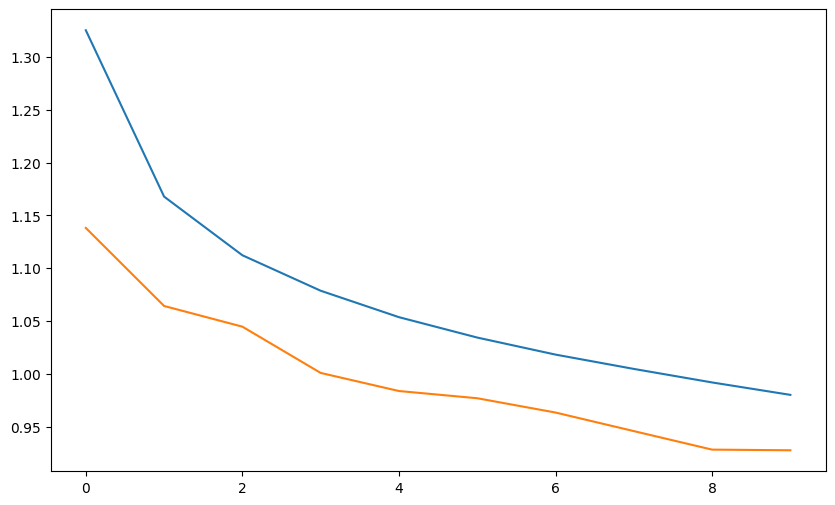

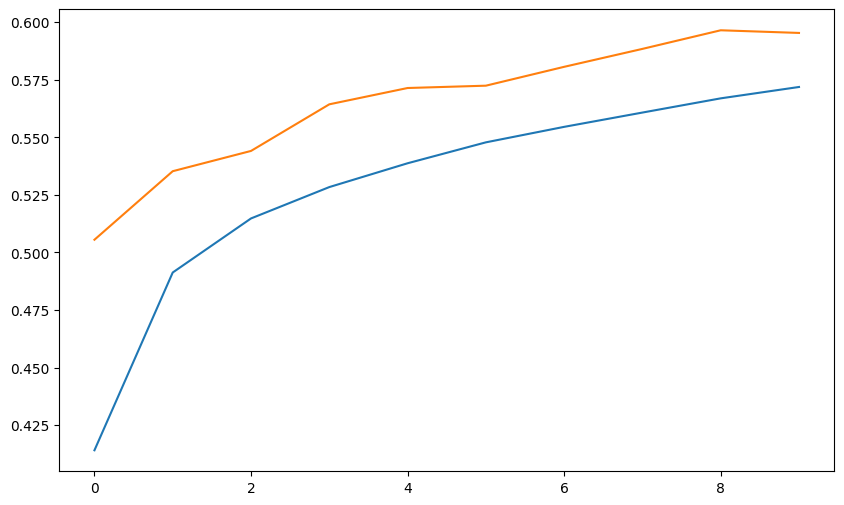

evaluating...: 100%|██████████| 98/98 [00:02<00:00, 38.57it/s]

test_loss: 0.958, test_acc: 0.581


In [ ]:

# build the model

class lstm(nn.Module):
  def __init__(self,input_size, embed_dim, output_dim, n_layers):
    super().__init__()
    self.embedding = nn.Embedding(input_size, embed_dim)
    self.lstm= nn.LSTM(embed_dim, embed_dim, num_layers=n_layers, batch_first=True)
    self.fc = nn.Linear(embed_dim, output_dim)
    self.dropout = nn.Dropout(0.5)

  def forward(self,ids,length):
    embedded = self.dropout(self.embedding(ids))
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, enforce_sorted=False)
    packed_output, (hidden, cell) = self.lstm(packed_embedded)
    output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
    prediction = self.fc(hidden[-1])
    return prediction

input_size = len(vocab)
embed_dim = 100
output_dim = 5
n_layers = 2

model = lstm(input_size, embed_dim, output_dim, n_layers)

# initialize the embedding weight using random
embedding_layer = nn.Embedding(input_size, embed_dim)
embedding_layer.weight.data.uniform_(-1, 1)

# import optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)


# define function to get accuracy with predition and label
def get_accuracy(prediction, label):
  batch_size, _ = prediction.shape
  predicted_classes = prediction.argmax(dim=-1)
  correct_predictions = predicted_classes.eq(label).sum()
  accuracy = correct_predictions / batch_size
  return accuracy


# define function to evaluate model
def evaluate(data_loader, model, criterion, device):
  model.eval()
  epoch_losses = []
  epoch_accs = []
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
      ids = batch["ids"].to(device)
      length = batch["length"]
      label = batch["label"].to(device)
      prediction = model(ids, length)
      loss = criterion(prediction, label)
      accuracy = get_accuracy(prediction, label)
      epoch_losses.append(loss.item())
      epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses), np.mean(epoch_accs)

# define train function
def train(data_loader, model, criterion, optimizer, device):
  model.train()
  epoch_losses = []
  epoch_accs = []
  for batch in tqdm.tqdm(data_loader, desc="training..."):
    ids = batch["ids"].to(device)
    length = batch["length"]
    label = batch["label"].to(device)
    prediction = model(ids, length)
    loss = criterion(prediction, label)
    accuracy = get_accuracy(prediction, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses), np.mean(epoch_accs)

# loop through epochs to train
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
  train_loss, train_acc = train(train_dataset_loader, model, criterion, optimizer, device)
  valid_loss, valid_acc = evaluate(valid_dataset_loader, model, criterion, device)
  metrics["train_losses"].append(train_loss)
  metrics["train_accs"].append(train_acc)
  metrics["valid_losses"].append(valid_loss)
  metrics["valid_accs"].append(valid_acc)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), "nbow.pt")
  print(f"epoch: {epoch}")
  print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")

# plot the train and valid loss with epoch
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
plt.show()

# plot the train and valid accuracy with epoch
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
plt.show()

# calculate the accuracy on test
test_loss, test_acc = evaluate(test_dataset_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")